#Install Dependencies and Import Libraries

In [ ]:
import sys
!{sys.executable} -m pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 49.3 MB/s eta 0:00:00


In [ ]:
import sys
!{sys.executable} -m pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPoint
from geopy.distance import distance
from pyproj import Proj, transform
import requests
import json

# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_PATH = '/content/drive/MyDrive/WILDFIRE/Database/Wildfire_updt'

In [ ]:
## read in data that has more information on each fire
fire= pd.read_csv(BASE_PATH + '/Wildland_Fire_Incident_Locations.csv')

# Format Data to Desired Forms

In [ ]:
## this is the NASA satalite data
firesat = pd.read_csv(BASE_PATH + "/fire.csv")

In [ ]:
## making coordinates out of lat and long points
fire['coords']=list(zip(fire['X'],fire['Y']))
fire['coords'] = fire['coords'].apply(Point)
fire['initial_coords']=list(zip(fire['InitialLongitude'],fire['InitialLatitude']))
fire['initial_coords']=fire['initial_coords'].apply(Point)

In [ ]:
firesat['coords']=list(zip(firesat['longitude'],firesat['latitude']))
firesat['coords'] = firesat['coords'].apply(Point)

In [ ]:
for i in ['FireDiscoveryDateTime', 'ICS209ReportDateTime', 'ICS209ReportForTimePeriodFrom', 'ICS209ReportForTimePeriodTo']:
    fire[i]=pd.to_datetime(fire[i])

In [ ]:
f = fire[['IncidentName', 'FireDiscoveryDateTime', 'ICS209ReportDateTime', 'ICS209ReportForTimePeriodFrom', 'ICS209ReportForTimePeriodTo']]
f=f.groupby(['IncidentName'])['FireDiscoveryDateTime'].min()
f=pd.DataFrame(f)
f.reset_index(inplace=True)
fire = fire.merge(f, how='left', on='IncidentName')
fire = fire[fire['FireDiscoveryDateTime_y']>='2019-01-01']
fire = fire[fire['FireDiscoveryDateTime_y']<'2020-01-01']
for i in ['ContainmentDateTime', 'FireOutDateTime', 'InitialResponseDateTime']:
    fire[i]=pd.to_datetime(fire[i])
f= fire.groupby(['IncidentName'])['ContainmentDateTime'].min()
f=pd.DataFrame(f)
f.reset_index(inplace=True)
fire = fire.merge(f, how='left', on='IncidentName')

f= fire.groupby(['IncidentName'])['FireOutDateTime'].min()
f=pd.DataFrame(f)
f.reset_index(inplace=True)
fire = fire.drop('FireOutDateTime', axis=1)
fire = fire.merge(f, how='left', on='IncidentName')

f= fire.groupby(['IncidentName'])['InitialResponseDateTime'].mean()
f=pd.DataFrame(f)
f.reset_index(inplace=True)
fire = fire.drop('InitialResponseDateTime', axis=1)
fire = fire.merge(f, how='left', on='IncidentName')

f= fire.groupby(['IncidentName'])['DiscoveryAcres'].min()
f=pd.DataFrame(f)
f.reset_index(inplace=True)
fire = fire.drop('DiscoveryAcres', axis=1)
fire = fire.merge(f, how='left', on='IncidentName')
fire = fire.drop(columns=['ContainmentDateTime_x', 'FireDiscoveryDateTime_x', 'ICS209ReportDateTime', 'ICS209ReportForTimePeriodFrom', 'ICS209ReportForTimePeriodTo','ControlDateTime'])

In [ ]:
fire1 = fire[['IncidentName', 'DiscoveryAcres', 'FireBehaviorGeneral', 'FireBehaviorGeneral1', 'FireCause', 'FireCauseGeneral', 'FireCauseSpecific', 'FireOutDateTime', 'InitialResponseAcres', 'InitialResponseDateTime', 'PredominantFuelGroup', 'PrimaryFuelModel', 'SecondaryFuelModel', 'FireDiscoveryDateTime_y', 'ContainmentDateTime_y', 'coords']]

In [ ]:
fire1.head()

,IncidentName,DiscoveryAcres,FireBehaviorGeneral,FireBehaviorGeneral1,FireCause,FireCauseGeneral,FireCauseSpecific,FireOutDateTime,InitialResponseAcres,InitialResponseDateTime,PredominantFuelGroup,PrimaryFuelModel,SecondaryFuelModel,FireDiscoveryDateTime_y,ContainmentDateTime_y,coords
0,#2 BLM ASSIST,0.1,NaN,NaN,Undetermined,NaN,NaN,NaT,0.1,NaT,NaN,NaN,NaN,2019-06-24 23:19:37+00:00,NaT,POINT (-112.4873 36.90229)
1,#2 LEFTHAND,0.1,NaN,NaN,Human,NaN,NaN,2019-11-07 21:59:59+00:00,0.1,NaT,NaN,NaN,NaN,2019-10-17 18:30:00+00:00,2019-10-17 19:30:00+00:00,POINT (-108.4736 42.96146)
2,#39 Hwy 1806,NaN,NaN,NaN,Undetermined,Other Human Cause,NaN,NaT,NaN,NaT,NaN,NaN,NaN,2019-07-21 04:36:00+00:00,2019-07-21 05:19:59+00:00,POINT (-100.8807 46.82745)
3,#9155,0.2,NaN,NaN,Human,NaN,NaN,2019-11-18 21:35:00+00:00,0.2,NaT,NaN,NaN,NaN,2019-11-14 18:24:59+00:00,2019-11-14 20:10:00+00:00,POINT (-119.889 43.56725)
4,(07) BRIDGES LANE,NaN,NaN,NaN,Human,Debris/Open Burning,NaN,NaT,NaN,NaT,NaN,NaN,NaN,2019-05-20 18:20:00+00:00,2019-05-20 22:59:00+00:00,POINT (-85.1637 30.24781)


In [ ]:
fire1 = fire1.dropna(subset=['IncidentName', 'PrimaryFuelModel'])

In [ ]:
groups = fire1.groupby('IncidentName')
for IncidentName, group in groups:
    for col in group.columns[group.isnull().any()]:
        non_missing = group.loc[group[col].notnull(), col]
        if len(non_missing)>0:
            fire1.loc[group.index, col] = non_missing.iloc[0]

In [ ]:
fire1=fire1.dropna(subset=['ContainmentDateTime_y', 'FireOutDateTime'], how='all')
enddate = {'ContainmentDateTime_y':fire1['FireOutDateTime'], 'FireOutDateTime':fire1['ContainmentDateTime_y']}
fire1 = fire1.fillna(value=enddate)

In [ ]:
fire2=fire1[['IncidentName', 'DiscoveryAcres', 'FireCause', 'FireOutDateTime', 'PrimaryFuelModel', 'SecondaryFuelModel', 'FireDiscoveryDateTime_y', 'ContainmentDateTime_y', 'coords']]
fire2 = fire2.sort_values(['IncidentName', 'DiscoveryAcres'], ascending=False)

In [ ]:
fire3 = fire2.drop_duplicates(subset=['IncidentName', 'FireCause', 'PrimaryFuelModel', 'SecondaryFuelModel'], keep='first')

In [ ]:
fire3['SecondaryFuelModel'] = fire3['SecondaryFuelModel'].fillna(fire3['PrimaryFuelModel'])

<ipython-input-21-681cd1c96540>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire3['SecondaryFuelModel'] = fire3['SecondaryFuelModel'].fillna(fire3['PrimaryFuelModel'])


In [ ]:
fire3=fire3.drop_duplicates(subset='IncidentName', keep=False)

In [ ]:
## read the fire perimeter data into a GeoDataFrame
fireper = gpd.GeoDataFrame.from_file(BASE_PATH + "/EventPolygon2019.shp")

In [ ]:
fireper = fireper[fireper['MapMethod']!="Hand Sketch"]

In [ ]:
sum(fireper.geometry.isna())

9

In [ ]:
fireper.dropna(subset=['geometry'], inplace=True)

In [ ]:
fireper_area_sorted = fireper.sort_values('SHAPE_Area', kind = 'mergesort', ascending = False)
fireper_area_sorted['area_sqKM'] = fireper_area_sorted['geometry'].to_crs({'init': 'epsg:3395'})\
               .map(lambda p: p.area / 10**6)
fireper_area_sorted.head() # SHAPE_Area = cylindrical area, area_sqKM is normal area

In [ ]:
fireper_area_sorted.head(1)

,OBJECTID,IncidentNa,FeatureCat,MapMethod,Comments,GISAcres,DeleteThis,Label,FeatureAcc,FeatureSta,...,IRWINID,GeometryID,GlobalID,GDB_FROM_D,GDB_TO_DAT,ORIGINAL_O,SHAPE_Leng,SHAPE_Area,geometry,area_sqKM
33453,776930,Old Grouch Top,Wildfire Daily Fire Perimeter,Image Interpretation,Perimeter updated using Sentinel-2 imagery; su...,307968.7,No,NaN,Public,Approved,...,{B8D9BDC9-4E15-4D16-8168-C77BDCAC01E7},{11D748E3-DF7A-43FC-A7FB-DC9264B9CECF},{48BC64D2-C99B-484E-9450-C21390ABA9BC},2019-07-18,2019-11-23,198451,7.86974,0.22153,"POLYGON ((-157.59521 63.20091, -157.61115 63.1...",6062.646029


In [ ]:
fireper_sorted_areasqkm = fireper_area_sorted.sort_values('area_sqKM', ascending = False)
fireper_sorted_areasqkm.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 35291 entries, 28296 to 29209
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    35291 non-null  int64   
 1   IncidentNa  34935 non-null  object  
 2   FeatureCat  35291 non-null  object  
 3   MapMethod   35252 non-null  object  
 4   Comments    30840 non-null  object  
 5   GISAcres    33747 non-null  float64 
 6   DeleteThis  35291 non-null  object  
 7   Label       1258 non-null   object  
 8   FeatureAcc  35277 non-null  object  
 9   FeatureSta  35242 non-null  object  
 10  IsVisible   35257 non-null  object  
 11  CreateDate  35291 non-null  object  
 12  DateCurren  35291 non-null  object  
 13  PolygonDat  31877 non-null  object  
 14  ComplexNam  1025 non-null   object  
 15  ComplexID   951 non-null    object  
 16  GACC        33734 non-null  object  
 17  IMTName     2274 non-null   object  
 18  UnitID      6483 non-null   object

In [ ]:
fireper_sorted_areasqkm['IncidentNa'].dropna(axis = 0).unique()[0:12]

array(['Frozen Calf', 'Old Grouch Top', 'Hess Creek', nan,
       'Bearnose Hill', 'Swan Lake', 'Black River', 'North River',
       'Tractor Trail 2', 'Little Mud River', 'Little Crazy Mountain',
       'Hurst Creek'], dtype=object)

In [ ]:
fireper_sorted_areasqkm['IncidentNa'].dropna(axis = 0).unique()[-12]

'Cheney Creek  MM 2'

In [ ]:
fireper_sorted_areasqkm.dropna(axis = 0).iloc[-1,:]

OBJECTID                                                 752520
IncidentNa                                           Coal River
FeatureCat                        Wildfire Daily Fire Perimeter
MapMethod                                                 Other
Comments                       Pulled from WFDSS data 7/19/2019
GISAcres                                             115.353575
DeleteThis                                                   No
Label                                                       601
FeatureAcc                                               Public
FeatureSta                                             Approved
IsVisible                                                   Yes
CreateDate                                           2019-07-18
DateCurren                                           2019-07-22
PolygonDat                                           2019-07-17
ComplexNam                                   Cornucopia Complex
ComplexID                               

In [ ]:
# fireper_area_sorted1 =fireper_area_sorted.copy()
# fireper_area_sorted1 = fireper_area_sorted.to_crs({'init': 'epsg:3857'})
# print(fireper_area_sorted1.crs)
# fireper_area_sorted1.head()

In [ ]:
# fireper_area_sorted1['area_sqKM'] = fireper_area_sorted1['geometry'].area/10**6
# fireper_area_sorted1.head()

In [ ]:
print(-.05*fireper['SHAPE_Area'].std()+fireper['SHAPE_Area'].mean())

0.0009394668443162711


In [ ]:
print(sum(fireper['SHAPE_Area'].isna()))
print(sum(fireper['IncidentNa'].isna()))

0
356


In [ ]:
print(sum(fireper['SHAPE_Area']<0.0000000245))
#fireper1 = fireper[fireper['SHAPE_Area']>0.0000000245]

6075


In [ ]:
print(fireper['IncidentNa'].duplicated().sum())

11600


In [ ]:
## If the polygon has a hole in it, then this fills the hole
filled_fireper = gpd.GeoDataFrame(columns=fireper.columns)
for index, row in fireper.iterrows():
    if row['geometry'].type == 'Polygon' and len(row['geometry'].interiors)>0:
        exterior_coords = list(row['geometry'].exterior.coords)
        interior_coords = []
        for hole in row['geometry'].interiors:
            interior_coords.extend(list(hole.coords))
        new_polygon = Polygon(exterior_coords + interior_coords)
        filled_fireper = filled_fireper.append({'geometry': new_polygon}, ignore_index=True)
    else:
        filled_fireper = filled_fireper.append(row, ignore_index=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-24-b3f08cc67159>:4: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if row['geometry'].type == 'Polygon' and len(row['geometry'].interiors)>0:
<ipython-input-24-b3f08cc67159>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filled_fireper = filled_fireper.append(row, ignore_index=True)
<ipython-input-24-b3f08cc67159>:4: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if row['geometry'].type == 'Polygon' and len(row['geometry'].interiors)>0:
<ipython-input-24-b3f08cc67159>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filled_fireper = filled_firepe

In [ ]:
filled_fireper1=filled_fireper[filled_fireper['DeleteThis']=='No']
filled_fireper1=filled_fireper1.drop(columns="DeleteThis")

In [ ]:
filled_fireper1.to_file("filled_fireper1.shp")

In [ ]:
filled_fireper = gpd.GeoDataFrame.from_file("filled_fireper1.shp")

DriverError: Operational_Data_Archive_2019/filled_fireper1.shp: No such file or directory

In [ ]:
filled_fireper.dropna(subset=['geometry', 'SHAPE_Area', 'GISAcres'], inplace=True)
filled_fireper = filled_fireper[filled_fireper['GISAcres']>0]
filled_fireper = filled_fireper[filled_fireper['SHAPE_Area']>0]

In [ ]:
filled_fireper['missing_data'] = filled_fireper.isnull().sum(axis=1)

In [ ]:
filled_fireper = filled_fireper.sort_values(['IncidentNa', 'SHAPE_Area', 'missing_data'], ascending=False)

In [ ]:
for i in ['CreateDate', 'GDB_TO_DAT', 'GDB_FROM_D', 'DateCurren']:
    filled_fireper[i]=pd.to_datetime(filled_fireper[i])

In [ ]:
filled_fireper.iloc[110]

OBJECTID                                                   745751
IncidentNa                                              napamiute
FeatureCat                          Wildfire Daily Fire Perimeter
MapMethod                                          Auto-generated
Comments                              Auto-generated by EGP-IRWIN
GISAcres                                                      5.0
Label                                                         NaN
FeatureAcc                                            Cooperators
FeatureSta                                               proposed
IsVisible                                                      -1
CreateDate                                    2019-06-01 00:00:00
DateCurren                                    2019-06-01 00:00:00
PolygonDat                                             2019-06-01
ComplexNam                                                    NaN
ComplexID                                                     NaN
GACC      

In [ ]:
filled_fireper.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 33471 entries, 18204 to 19223
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   OBJECTID      33471 non-null  object        
 1   IncidentNa    33433 non-null  object        
 2   FeatureCat    33471 non-null  object        
 3   MapMethod     33439 non-null  object        
 4   Comments      30370 non-null  object        
 5   GISAcres      33471 non-null  float64       
 6   Label         1127 non-null   object        
 7   FeatureAcc    33460 non-null  object        
 8   FeatureSta    33432 non-null  object        
 9   IsVisible     33439 non-null  object        
 10  CreateDate    33471 non-null  datetime64[ns]
 11  DateCurren    33471 non-null  datetime64[ns]
 12  PolygonDat    31548 non-null  object        
 13  ComplexNam    968 non-null    object        
 14  ComplexID     872 non-null    object        
 15  GACC          33058 non-

In [ ]:
ff = filled_fireper[['IncidentNa', 'CreateDate', 'GDB_TO_DAT', 'GDB_FROM_D', 'SHAPE_Area']].drop_duplicates(subset=None, keep='first')
ff = ff.sort_values('CreateDate').groupby(by='IncidentNa')

ff.head()

,IncidentNa,CreateDate,GDB_TO_DAT,GDB_FROM_D,SHAPE_Area
781,ROSS,2019-04-25,2019-05-03,2019-04-25,2.712667e-08
804,SQUAD,2019-04-25,2019-05-03,2019-04-25,2.186300e-07
790,Fish Springs RX Avocet Unit,2019-04-25,2019-05-03,2019-04-25,2.507633e-08
814,2019-142-001,2019-04-25,2019-04-26,2019-04-25,1.128831e-07
846,2019-142-001,2019-04-25,2019-04-25,2019-04-25,2.258022e-07
...,...,...,...,...,...
34938,591 MF,2019-12-31,2020-01-10,2019-12-31,2.361341e-08
34884,4F,2019-12-31,2020-01-03,2019-12-31,1.722189e-06
35023,COLD STONE,2019-12-31,2020-01-17,2019-12-31,2.618856e-08
34930,LAC-402158,2019-12-31,2020-01-10,2019-12-31,2.703983e-08


In [ ]:
unique_incident_names = ff['IncidentNa'].unique()

In [ ]:
incident_to_min_date = {}

In [ ]:
filled_fireper.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 33471 entries, 18204 to 19223
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   OBJECTID      33471 non-null  object        
 1   IncidentNa    33433 non-null  object        
 2   FeatureCat    33471 non-null  object        
 3   MapMethod     33439 non-null  object        
 4   Comments      30370 non-null  object        
 5   GISAcres      33471 non-null  float64       
 6   Label         1127 non-null   object        
 7   FeatureAcc    33460 non-null  object        
 8   FeatureSta    33432 non-null  object        
 9   IsVisible     33439 non-null  object        
 10  CreateDate    33471 non-null  datetime64[ns]
 11  DateCurren    33471 non-null  datetime64[ns]
 12  PolygonDat    31548 non-null  object        
 13  ComplexNam    968 non-null    object        
 14  ComplexID     872 non-null    object        
 15  GACC          33058 non-

In [ ]:
for incident in unique_incident_names:
  all_data_for_incident = filled_fireper[filled_fireper['IncidentNa'] == incident[0]]

  all_dates = []
  all_dates.append(min(all_data_for_incident['CreateDate']))
  all_dates.append(min(all_data_for_incident['DateCurren']))
  all_dates.append(min(all_data_for_incident['GDB_FROM_D']))
  all_dates.append(min(all_data_for_incident['GDB_TO_DAT']))

  min_date_for_incident = min(all_dates)

  incident_to_min_date[incident[0]] = min_date_for_incident


In [ ]:
filled_fireper['minDate'] = None

In [ ]:
for incident in unique_incident_names:
  temp = filled_fireper[filled_fireper['IncidentNa'] == incident[0]]
  temp['minDate'] = incident_to_min_date[incident[0]] 
  filled_fireper[filled_fireper['IncidentNa'] == incident[0]] = temp

/usr/local/lib/python3.9/dist-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
filled_fireper['minDate']

18204    2019-08-14 00:00:00
27812    2019-09-30 00:00:00
17379    2019-08-09 00:00:00
23654    2019-08-24 00:00:00
18670    2019-08-03 00:00:00
                ...         
10271                   None
10138                   None
23990                   None
19351                   None
19223                   None
Name: minDate, Length: 33471, dtype: object

In [ ]:
filled_fireper['merged_poly'] = None

In [ ]:
from shapely.ops import unary_union

for incident in unique_incident_names:
  temp = filled_fireper[filled_fireper['IncidentNa'] == incident[0]]
  merged_poly = unary_union(temp.geometry)

  temp['merged_poly'] = merged_poly
  filled_fireper[filled_fireper['IncidentNa'] == incident[0]] = temp

/usr/local/lib/python3.9/dist-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
filled_fireper.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 33471 entries, 18204 to 19223
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   OBJECTID      33471 non-null  object        
 1   IncidentNa    33433 non-null  object        
 2   FeatureCat    33471 non-null  object        
 3   MapMethod     33439 non-null  object        
 4   Comments      30370 non-null  object        
 5   GISAcres      33471 non-null  float64       
 6   Label         1127 non-null   object        
 7   FeatureAcc    33460 non-null  object        
 8   FeatureSta    33432 non-null  object        
 9   IsVisible     33439 non-null  object        
 10  CreateDate    33471 non-null  datetime64[ns]
 11  DateCurren    33471 non-null  datetime64[ns]
 12  PolygonDat    31548 non-null  object        
 13  ComplexNam    968 non-null    object        
 14  ComplexID     872 non-null    object        
 15  GACC          33058 non-

In [ ]:
date_data = filled_fireper[['OBJECTID', 'IncidentNa', 'CreateDate', 'DateCurren', 'GDB_FROM_D', 'GDB_TO_DAT', 'minDate']]

In [ ]:
date_data.to_csv(BASE_PATH + '/filled_fireper_DATE_data_MARCH_30.csv')

In [ ]:
filled_fireper = filled_fireper.drop(['CreateDate', 'DateCurren', 'GDB_FROM_D', 'GDB_TO_DAT', 'minDate'], axis=1)

In [ ]:
filled_fireper[['OBJECTID', 'IncidentNa', 'geometry']].to_file(BASE_PATH + '/filled_fireper_NOT_MERGED_MARCH_30.shp')

In [ ]:
temp = filled_fireper

In [ ]:
temp['geometry'] = temp['merged_poly']

In [ ]:
filled_fireper[['OBJECTID', 'IncidentNa', 'geometry']].to_file(BASE_PATH + '/filled_fireper_MERGED_POLY_MARCH_30.shp')

In [ ]:
temp2 = filled_fireper.drop(['geometry', 'merged_poly'], axis=1)

In [ ]:
temp2.to_csv(BASE_PATH + '/filled_fireper_NON_POLY_DATADATE_data_MARCH_30.csv')

In [ ]:
filled_fireper.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 33471 entries, 18204 to 19223
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   OBJECTID      33471 non-null  object        
 1   IncidentNa    33433 non-null  object        
 2   FeatureCat    33471 non-null  object        
 3   MapMethod     33439 non-null  object        
 4   Comments      30370 non-null  object        
 5   GISAcres      33471 non-null  float64       
 6   Label         1127 non-null   object        
 7   FeatureAcc    33460 non-null  object        
 8   FeatureSta    33432 non-null  object        
 9   IsVisible     33439 non-null  object        
 10  CreateDate    33471 non-null  datetime64[ns]
 11  DateCurren    33471 non-null  datetime64[ns]
 12  PolygonDat    31548 non-null  object        
 13  ComplexNam    968 non-null    object        
 14  ComplexID     872 non-null    object        
 15  GACC          33058 non-

In [ ]:
ff = filled_fireper.groupby(by='IncidentNa', axis=0).max('SHAPE_Area')
ff.head()

,GISAcres,SHAPE_Leng,SHAPE_Area,missing_data
IncidentNa,,,,
,100.0,0.019233,1.300170e-05,6
# 1 F/A-TCA-BIA,0.1,0.000748,2.646785e-08,6
# 1 San Saba 17:41,5.0,0.005415,1.397790e-06,6
# 2 FRACAS,0.1,0.000745,2.619995e-08,6
# 4 MACKELPRANG,0.5,0.001667,1.313613e-07,6


In [ ]:
fire.head()

,X,Y,OBJECTID,SourceOID,ADSPermissionState,ContainmentDateTime,ControlDateTime,IncidentSize,DiscoveryAcres,DispatchCenterID,...,SecondaryFuelModel,UniqueFireIdentifier,OrganizationalAssessment,StrategicDecisionPublishDate,CreatedOnDateTime_dt,ModifiedOnDateTime_dt,SourceGlobalID,GlobalID,coords,initial_coords
0,-118.180712,33.808985,1,7747595,DEFAULT,NaN,NaN,NaN,0.10,CALACC,...,NaN,2020-CALAC-066100,NaN,NaN,2020-02-28 20:52:36+00:00,2020/02/28 20:52:36+00,{6A311ABB-DF4F-4947-B8DD-3900BDA784F6},{48D2C0E2-5E38-4D40-9D5E-066B076C7D98},POINT (-118.1807122 33.80898483),POINT (-118.1807 33.80898)
1,-117.153901,33.176394,2,6384391,DEFAULT,NaN,NaN,NaN,NaN,CAMVIC,...,NaN,2019-CAMVU-009269,NaN,NaN,2019-07-01 20:10:12+00:00,2019/07/01 20:10:12+00,{1AF2C949-B159-4D8F-8D39-90CB58BC5DD5},{17D2D66A-D451-4592-A172-7B2C860A2CC9},POINT (-117.1539008 33.17639371),POINT EMPTY
2,-121.104180,38.834727,3,1383752,DEFAULT,NaN,NaN,NaN,NaN,NaN,...,NaN,2016-CANEU-014375,NaN,NaN,2016-06-20 22:39:02+00:00,2016/06/20 22:39:02+00,{1B179EA1-97CE-4699-915B-374754BCBC5B},{60C471FF-3C85-41B4-9135-E7338D7EC90B},POINT (-121.1041798 38.83472735),POINT EMPTY
3,-117.228592,33.782442,4,22499589,DEFAULT,NaN,NaN,NaN,0.10,CARRCC,...,NaN,2021-CARRU-163915,NaN,NaN,2021-11-25 15:24:53+00:00,2021/11/25 15:24:53+00,{E61E387B-4ED7-4971-9604-C5D7391FAF77},{149237EC-A42E-43D6-9318-22207A705DD9},POINT (-117.228592 33.78244188),POINT (-117.22858 33.782437)
4,-118.309032,33.941815,5,23869477,DEFAULT,NaN,NaN,NaN,0.01,CALACC,...,NaN,2022-CALAC-396331,NaN,NaN,2022-11-21 11:28:49+00:00,2022/11/21 11:28:49+00,{AEB6F7A3-A109-4132-9FEB-FB1EE1DF3193},{EF7675E3-D5BE-412A-A6C1-0D63FC7153C8},POINT (-118.3090322 33.94181484),POINT (-118.30902 33.94181)


In [ ]:
fire['FireDiscoveryDateTime']=pd.to_datetime(fire['FireDiscoveryDateTime'])
fire['ContainmentDateTime']=pd.to_datetime(fire['ContainmentDateTime'])

In [ ]:
fire2 = fire.groupby(by='IncidentName', axis=0).min('FireDiscoveryDateTime')
fire2.head()

,X,Y,OBJECTID,SourceOID,IncidentSize,DiscoveryAcres,FinalAcres,FireStrategyConfinePercent,FireStrategyFullSuppPercent,InitialLatitude,InitialLongitude,InitialResponseAcres,IsFireCauseInvestigated,PercentContained,PercentPerimeterToBeContained
IncidentName,,,,,,,,,,,,,,,
\nOld Sundance,-102.544223,43.028513,254844,14042388,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
9901 Highway 10 West,-114.163413,46.964956,101273,8126380,1.0,1.0,NaN,NaN,NaN,46.96495,-114.1634,1.0,NaN,NaN,NaN
French,-123.106514,42.048105,215900,19960797,0.1,1.0,NaN,NaN,NaN,42.04810,-123.1065,NaN,NaN,NaN,NaN
K21,-103.185809,36.275626,147412,23832100,3.6,3.6,NaN,NaN,NaN,36.27562,-103.1860,3.6,NaN,NaN,NaN
Lorenzo,-100.460826,47.442178,290185,19918395,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
filled_fireper['expanded']=filled_fireper['geometry'].buffer(.00009)

In [ ]:
len(filled_fireper1.columns)

31

In [ ]:
filled_fireper1['overlap'] = 0
for i in range(len(filled_fireper1)):
    for j in range(i+1, len(filled_fireper1)):
        if (filled_fireper1.iloc[i, 2]!= filled_fireper1.iloc[j, 2]) and (filled_fireper1.iloc[i, 30]==0) and (filled_fireper1.iloc[j, 30]==0):
            if filled_fireper1.iloc[i, 28].intersects(filled_fireper1.iloc[j, 28]):
                filled_fireper1.iloc[i, 30]=j

KeyboardInterrupt: 

In [ ]:
id = filled_fireper[['OBJECTID', 'IncidentNa', 'GISAcres', 'GlobalID', 'SHAPE_Area', 'IRWINID']]
id.to_csv('fireperid.csv')

In [ ]:
id = filled_fireper[['OBJECTID', 'IncidentNa', 'GISAcres', 'GlobalID', 'SHAPE_Area', 'IRWINID', 'overlap']]
id.to_csv('fireperid.csv')

## Merging the Fire Sat Data set (Nasa) with the Polygon Dataset

In [ ]:
fireper = gpd.GeoDataFrame.from_file(BASE_PATH+"/filled_fireper_MERGED_POLY_MARCH_30.shp")

In [ ]:
fireper = fireper.astype({'OBJECTID':int})
fireper.tail()

In [ ]:
fireper_nonan = fireper.dropna(axis=0)
fireper_nonan.head()

In [ ]:
fireper1 = pd.read_csv(BASE_PATH + '/filled_fireper_NON_POLY_DATA_MARCH_30.csv')

In [ ]:
fireper1 = fireper1[['IncidentNa', 'OBJECTID', 'GISAcres', 'IsVisible', 'IRWINID', 'SHAPE_Area']]

In [ ]:
fireper1['missing_data'] = fireper1.isnull().sum(axis=1)

In [ ]:
fireper1 = fireper1.sort_values(['IncidentNa', 'SHAPE_Area', 'missing_data'], ascending=False)
fireper2=fireper1.drop_duplicates(subset='IncidentNa', keep='first')

In [ ]:
fireper2= pd.merge(fireper2, fire3, how='inner', left_on='IncidentNa', right_on='IncidentName')

In [ ]:
firesat['acq_date']=pd.to_datetime(firesat['acq_date'])

In [ ]:
firesat = firesat[(firesat['acq_date']>='2019-01-01') & (firesat['acq_date']<'2020-01-01')]

In [ ]:
points = gpd.GeoDataFrame(firesat, geometry='coords', crs=fireper.crs)

In [ ]:
wf = pd.merge(fireper, fireper2, on='OBJECTID', how='inner')

In [ ]:
wf['FireDiscoveryDateTime_y']=wf['FireDiscoveryDateTime_y']-pd.Timedelta(days=1)
wf['FireOutDateTime']=wf['FireOutDateTime']+pd.Timedelta(days=2)

In [ ]:
wf['FireDiscoveryDateTime_y'] = wf['FireDiscoveryDateTime_y'].apply(lambda x:x.tz_localize(None))

In [ ]:
wf1 = wf.iloc[[0]]
pointsinfire = gpd.tools.sjoin(points, wf1, predicate="within", how='inner')
pointsinfire = pointsinfire[(pointsinfire['acq_date']>=pointsinfire['FireDiscoveryDateTime_y']) & (pointsinfire['acq_date']<=pointsinfire['FireOutDateTime'])]

In [ ]:
wf = wf.iloc[1:]
for i in range(len(wf)):
    firepoints=wf.iloc[[i]]
    firepoints=gpd.tools.sjoin(points, firepoints, predicate='within', how='inner')
    if len(firepoints)>0:
        firepoints=firepoints[(firepoints['acq_date']>=firepoints['FireDiscoveryDateTime_y']) & (firepoints['acq_date']<=firepoints['FireOutDateTime'])]
    pointsinfire=pd.concat([pointsinfire, firepoints], ignore_index=True)

In [ ]:
pointsinfire=pointsinfire.sort_values(['IncidentName', 'acq_date', 'acq_time'])

In [ ]:
fire = pointsinfire.groupby(['IncidentName', 'acq_date', 'acq_time'])
perimeter = gpd.GeoDataFrame()
for (name, date, time), group in fire:
    if len(group)>1:
        points = MultiPoint(group[['longitude', 'latitude']].to_numpy())
        polygon = points.convex_hull
        perimeter = perimeter.append({'IncidentName':name, 'acq_date':date, 'acq_time':time, 'geometry':polygon}, ignore_index=True)

In [ ]:
perimeter = gpd.GeoDataFrame(perimeter)
perimeter['area'] = perimeter['geometry'].area

In [ ]:
## stop here
pointsinfire['time']= round(pointsinfire['acq_time']/100).astype(int).astype(str)

In [ ]:
pointsinfire

In [ ]:
# lat = 44.3
# long = -118.5
# start = '2019-08-20'
# end = '2019-08-20'
# url = 'https://archive-api.open-meteo.com/v1/archive'
# params = {'latitude': lat, 'longitude': long, 'start_date': start, 'end_date': end, 'timezone': 'auto', 'temperature_unit': 'fahrenheit',
#           'hourly': 'temperature_2m,dewpoint_2m,relativehumidity_2m,pressure_msl,precipitation,rain,snowfall,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm'}
# res = requests.get(url, params = params)
# #res = requests.get('https://archive-api.open-meteo.com/v1/archive?latitude=%7Blat%7D&longitude=%7Blong%7D&start_date=%7Bstart%7D&end_date=%7Bend%7D&hourly=relativehumidity_2m,pressure_msl,precipitation,rain,snowfall,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm&timezone=auto&temperature_unit=fahrenheit%27)
# response = json.loads(res.text)


In [ ]:
# response['hourly'].keys()

#Get Weather Data

In [ ]:
def get_weather_data(lat, long, start, end):
  url = 'https://archive-api.open-meteo.com/v1/archive'
  params = {'latitude': lat, 'longitude': long, 'start_date': start, 'end_date': end, 'temperature_unit': 'fahrenheit',
            'hourly': 'temperature_2m,dewpoint_2m,relativehumidity_2m,pressure_msl,precipitation,rain,snowfall,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm'}
  res = requests.get(url, params = params)
  #res = requests.get('https://archive-api.open-meteo.com/v1/archive?latitude=%7Blat%7D&longitude=%7Blong%7D&start_date=%7Bstart%7D&end_date=%7Bend%7D&hourly=relativehumidity_2m,pressure_msl,precipitation,rain,snowfall,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm&timezone=auto&temperature_unit=fahrenheit%27)
  response = json.loads(res.text)
  status_code = res.status_code

  if status_code == 200:
    weather = response.pop('hourly')
    #response_df = pd.DataFrame.from_dict(response)
    weather_df = pd.DataFrame.from_dict(weather)

    return status_code, weather_df
  else:
    print(response)
    print(status_code)
    return status_code, None


In [ ]:
#get_weather_data(lat, long, start, end)

In [ ]:
fire3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754 entries, 7846 to 18476
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   IncidentName             754 non-null    object             
 1   DiscoveryAcres           724 non-null    float64            
 2   FireCause                753 non-null    object             
 3   FireOutDateTime          754 non-null    datetime64[ns]     
 4   PrimaryFuelModel         754 non-null    object             
 5   SecondaryFuelModel       754 non-null    object             
 6   FireDiscoveryDateTime_y  754 non-null    datetime64[ns, UTC]
 7   ContainmentDateTime_y    754 non-null    datetime64[ns]     
 8   coords                   754 non-null    object             
dtypes: datetime64[ns, UTC](1), datetime64[ns](2), float64(1), object(5)
memory usage: 58.9+ KB


In [ ]:
fire3['FireDiscoveryDateTime_y'] = pd.to_datetime(fire3['FireDiscoveryDateTime_y'])
fire3['discoveryTime'] = pd.to_datetime(fire3['FireDiscoveryDateTime_y']).dt.tz_localize(None)
fire3['containmentTime'] = pd.to_datetime(fire3['ContainmentDateTime_y']).dt.tz_localize(None)

In [ ]:
#fire3['discoveryTime']
#fire3['containmentTime']

7846    2019-08-28 21:40:21
18229   2019-09-26 17:19:59
13012   2019-06-03 12:00:00
11522   2019-11-14 01:04:00
11178   2019-10-17 15:14:59
                ...        
11871   2019-07-12 18:59:59
8521    2019-07-18 16:54:59
17980   2019-10-04 17:50:00
12476   2019-12-01 18:59:59
18476   2019-11-25 17:00:00
Name: containmentTime, Length: 754, dtype: datetime64[ns]

In [ ]:
def date_string(date): #'2019-08-20'
  year = date.year
  month = date.month
  if month < 10:
    month = f'0{month}'
  day = date.day
  if day < 10:
    day = f'0{day}'

  dateString = f'{year}-{month}-{day}'
  return dateString


In [ ]:
weather_res = []
for i in range(len(fire3)):
  lat = fire3.iloc[i]['coords'].y
  long = fire3.iloc[i]['coords'].x
  start = date_string(fire3.iloc[i]['discoveryTime'])
  end = date_string(fire3.iloc[i]['containmentTime'])
  status_code, res = get_weather_data(lat, long, start, end)
  if status_code == 200:
    res['IncidentName'] = fire3.iloc[i]['IncidentName']
    weather_res.append(res)
  else:
    print('got an error, idx', i)
    print(start, end)


  

#Weather Data Info

In [ ]:
weather_data_df = pd.concat(weather_res)

In [ ]:
weather_data_df1 = pd.concat(weather_res)

In [ ]:
weather_data_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 922992 entries, 0 to 335
Data columns (total 5 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   time                       922992 non-null  object 
 1   temperature_2m             922992 non-null  float64
 2   dewpoint_2m                922992 non-null  float64
 3   soil_temperature_0_to_7cm  922992 non-null  float64
 4   IncidentName               922992 non-null  object 
dtypes: float64(3), object(2)
memory usage: 42.3+ MB


In [ ]:
weather_data_df.to_csv(BASE_PATH + '/WeatherDataDf.csv')

In [ ]:
weather_data_df1.to_csv(BASE_PATH + '/WeatherDataDf1.csv')

In [ ]:
weather_data_df.info()

In [ ]:
weather_data_df.info()

In [ ]:
weather_original = pd.read_csv(BASE_PATH + '/WeatherDataDf.csv')
weather1 = pd.read_csv(BASE_PATH + '/WeatherDataDf1.csv')

In [ ]:
combined_weather = pd.concat([weather1,weather_original.iloc[:,1:26]],axis = 1)
#combined_weather.info()
final_weather_data = combined_weather.iloc[:,1:29]
final_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 922992 entries, 0 to 922991
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   time                           922992 non-null  object 
 1   temperature_2m                 922992 non-null  float64
 2   dewpoint_2m                    922992 non-null  float64
 3   soil_temperature_0_to_7cm      922992 non-null  float64
 4   IncidentName                   922992 non-null  object 
 5   time                           777936 non-null  object 
 6   relativehumidity_2m            777936 non-null  float64
 7   pressure_msl                   777936 non-null  float64
 8   precipitation                  777936 non-null  float64
 9   rain                           777936 non-null  float64
 10  snowfall                       777936 non-null  float64
 11  cloudcover                     777936 non-null  float64
 12  cloudcover_low                

#Final Weather Data

In [ ]:
finalWeather = pd.read_csv(BASE_PATH + '/finalWeatherData.csv')
finalWeather.info()

In [ ]:
weather_data_df = pd.read_csv(BASE_PATH + "/finalWeatherData.csv").iloc[:,1:27]
weather_data_df.corr()

,temperature_2m,dewpoint_2m,relativehumidity_2m,pressure_msl,precipitation,rain,snowfall,cloudcover,cloudcover_low,cloudcover_mid,...,winddirection_100m,windgusts_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm
temperature_2m,1.000000,0.810505,-0.364592,-0.129344,0.002878,0.023279,-0.149614,-0.223010,-0.213448,-0.195958,...,0.053351,0.105103,0.937288,0.887485,0.803042,0.489297,-0.360037,-0.317427,-0.239143,-0.107723
dewpoint_2m,0.810505,1.000000,0.223560,-0.158143,0.116642,0.133293,-0.114101,0.030089,0.024072,-0.041213,...,0.024074,0.005736,0.715387,0.758464,0.692677,0.421982,-0.090905,-0.113093,-0.119298,-0.004421
relativehumidity_2m,-0.364592,0.223560,1.000000,-0.076944,0.223210,0.213153,0.088653,0.458855,0.447827,0.291754,...,-0.051269,-0.171771,-0.394607,-0.259205,-0.222457,-0.128961,0.445837,0.343349,0.201271,0.163796
pressure_msl,-0.129344,-0.158143,-0.076944,1.000000,-0.106838,-0.102303,-0.040487,-0.163146,-0.053390,-0.220283,...,-0.028053,-0.127306,-0.105656,-0.074320,-0.005868,0.100432,0.003177,0.020928,0.000735,-0.019583
precipitation,0.002878,0.116642,0.223210,-0.106838,1.000000,0.988947,0.151908,0.266402,0.248096,0.298578,...,-0.040321,0.164521,-0.002190,0.003088,0.002892,0.003121,0.177577,0.108950,0.063731,0.060831
rain,0.023279,0.133293,0.213153,-0.102303,0.988947,1.000000,0.004578,0.250354,0.231196,0.277688,...,-0.038868,0.156466,0.016570,0.022459,0.020623,0.013556,0.172298,0.104325,0.059923,0.058663
snowfall,-0.149614,-0.114101,0.088653,-0.040487,0.151908,0.004578,1.000000,0.137308,0.139696,0.173000,...,-0.012412,0.066888,-0.136212,-0.140510,-0.129127,-0.076749,0.052557,0.042421,0.033159,0.020457
cloudcover,-0.223010,0.030089,0.458855,-0.163146,0.266402,0.250354,0.137308,1.000000,0.788201,0.751738,...,-0.033591,0.136096,-0.237409,-0.255715,-0.265626,-0.259543,0.338986,0.259569,0.170420,0.170896
cloudcover_low,-0.213448,0.024072,0.447827,-0.053390,0.248096,0.231196,0.139696,0.788201,1.000000,0.390345,...,0.010807,0.151248,-0.211502,-0.211052,-0.187065,-0.140695,0.274681,0.210009,0.111703,0.107824
cloudcover_mid,-0.195958,-0.041213,0.291754,-0.220283,0.298578,0.277688,0.173000,0.751738,0.390345,1.000000,...,-0.064682,0.125066,-0.212600,-0.237255,-0.256144,-0.262029,0.279466,0.209222,0.152924,0.147664


In [ ]:
pointsinfire.head() 

In [ ]:
pointsinfire['dateTime'] = pointsinfire['acq_date'] + pointsinfire['time']
for i in range(1,len(pointsinfire)):
  if pointsinfire.iloc[i]['IncidentName'] == pointsinfire.iloc[i-1]['IncidentName']:
    pointsinfire.iloc[i]['dateTime']


#Operations to Format DateTime

In [ ]:
from datetime import datetime
pointsinfire['dateTime'] = pointsinfire['acq_date'].astype(str) + ' ' + pointsinfire['time']
#pointsinfire['dateTime'] = datetime.strptime(pointsinfire['dateTime'], '%Y-%d-%m %H')

In [ ]:
time1 = datetime.strptime(pointsinfire.iloc[0]['dateTime'], '%Y-%m-%d %H')

In [ ]:
pointsinfire['acq_date']

In [ ]:
arr_of_isotimes = []
for i in range(len(pointsinfire)):
  #pointsinfire.iloc[i]['dateTime'] = datetime.strptime(pointsinfire.iloc[i]['dateTime'], '%Y-%m-%d %H')
  year = pointsinfire.iloc[i].acq_date.year
  day = pointsinfire.iloc[i].acq_date.day
  month =  pointsinfire.iloc[i].acq_date.month
  hour = int(pointsinfire.iloc[i].time)

  
  arr_of_isotimes.append(datetime(year, month, day, hour).isoformat())
  # temp = datetime(year, month, day, hour).isoformat()
  # print(year, month, day, hour)
  # print(temp)


In [ ]:
pointsinfire['isotimes'] = arr_of_isotimes

In [ ]:
pointsinfire['isotimes']

10903    2019-08-20T09:00:00
10904    2019-08-20T11:00:00
10905    2019-08-20T20:00:00
10906    2019-08-20T20:00:00
10907    2019-08-20T20:00:00
                ...         
1        2019-05-23T07:00:00
2        2019-05-23T07:00:00
3        2019-05-23T07:00:00
4        2019-05-23T07:00:00
5        2019-05-24T07:00:00
Name: isotimes, Length: 12031, dtype: object

In [ ]:
weather_data_df['time'] 

In [ ]:
perimeter.head(4)

In [ ]:
perimeter.acq_time = perimeter.acq_time//100

In [ ]:
arr_of_isotimes = []
for i in range(len(perimeter)):
  #pointsinfire.iloc[i]['dateTime'] = datetime.strptime(pointsinfire.iloc[i]['dateTime'], '%Y-%m-%d %H')
  year = perimeter.iloc[i].acq_date.year
  day = perimeter.iloc[i].acq_date.day
  month =  perimeter.iloc[i].acq_date.month
  hour = perimeter.iloc[i].acq_time
  arr_of_isotimes.append(datetime(year, month, day, hour).isoformat())

In [ ]:
perimeter['isotimes'] = arr_of_isotimes

In [ ]:
perimeter

In [ ]:
perimeter.info()

In [ ]:
drop_arr = []
for i in range(len(perimeter)-1):
  if perimeter.iloc[i]['IncidentName']== perimeter.iloc[i+1]['IncidentName']:
    if perimeter.iloc[i]['area'] > perimeter.iloc[i+1]['area']:
      drop_arr.append(True)
    else:
      drop_arr.append(False)
  else:
    drop_arr.append(False)

drop_arr.append(False)

In [ ]:
perimeter['drop'] = drop_arr

In [ ]:
second_perimeter = perimeter[perimeter['drop']==False]

In [ ]:
# don't run the for loop yet - returns NaN's
# loops for average of all variables in the weather data for the time duration
mwi = []
for i in range (1, len(second_perimeter)):
  if second_perimeter.iloc[i]['IncidentName'] == second_perimeter.iloc[i-1]['IncidentName']:
    start, end = second_perimeter.iloc[i-1]['isotimes'], second_perimeter.iloc[i]['isotimes'] 
    weatherIncident = weather_data_df[weather_data_df['IncidentName'] == second_perimeter.iloc[i-1]['IncidentName']]
    weatherIncident = weatherIncident[(weatherIncident['time'] >= start) & (weatherIncident['time'] <= end)]
    temp = weatherIncident.drop(['time'], axis=1)
    mean_weatherIncident = temp.mean()

    mean_weatherIncident = pd.DataFrame(mean_weatherIncident).T

    mean_weatherIncident['startTime'] = start
    mean_weatherIncident['endTime'] = end
    mean_weatherIncident['IncidentName'] = second_perimeter.iloc[i-1]['IncidentName']
    mwi.append(mean_weatherIncident)



In [ ]:
second_mwi_df = pd.concat(mwi)

In [ ]:
# don't run the for loop yet - returns NaN's
# loops for average of all variables in the weather data for the time duration
mwi = []
for i in range (1, len(perimeter)):
  if perimeter.iloc[i]['IncidentName'] == perimeter.iloc[i-1]['IncidentName']:
    start, end = perimeter.iloc[i-1]['isotimes'], perimeter.iloc[i]['isotimes'] 
    weatherIncident = weather_data_df[weather_data_df['IncidentName'] == perimeter.iloc[i-1]['IncidentName']]
    weatherIncident = weatherIncident[(weatherIncident['time'] >= start) & (weatherIncident['time'] <= end)]
    temp = weatherIncident.drop(['time'], axis=1)
    mean_weatherIncident = temp.mean()

    mean_weatherIncident = pd.DataFrame(mean_weatherIncident).T

    mean_weatherIncident['startTime'] = start
    mean_weatherIncident['endTime'] = end
    mean_weatherIncident['IncidentName'] = perimeter.iloc[i-1]['IncidentName']
    mwi.append(mean_weatherIncident)



In [ ]:
mwi_df = pd.concat(mwi)

In [ ]:
mwi_df.head()

In [ ]:
mwi_df = mwi_df.sort_values(['IncidentName', 'startTime'], ascending=True)

In [ ]:
second_mwi_df = second_mwi_df.sort_values(['IncidentName', 'startTime'], ascending=True)

In [ ]:
mwi_df.head()

In [ ]:
mwi_df.info()

In [ ]:
perimeter.info()

In [ ]:
perimeter1 = pd.merge(perimeter, mwi_df, left_on=['IncidentName', 'isotimes'], right_on=['IncidentName', 'endTime'], how='left')

In [ ]:
second_perimeter1 = pd.merge(second_perimeter, second_mwi_df, left_on=['IncidentName', 'isotimes'], right_on=['IncidentName', 'endTime'], how='left')

In [ ]:
perimeter1 = perimeter1.drop(['area_change', 'area_roc'], axis=1)

#Change in Area

In [ ]:
area_change = [0]
area_roc = [0]

for i in range(1, len(second_perimeter1)):
  if second_perimeter1.iloc[i]['IncidentName']==second_perimeter1.iloc[i-1]['IncidentName']:
    area_change.append(second_perimeter1.iloc[i]['area']-second_perimeter1.iloc[i-1]['area'])
    area_roc.append((second_perimeter1.iloc[i]['area']-second_perimeter1.iloc[i-1]['area'])/second_perimeter1.iloc[i-1]['area'])
  else:
    area_change.append(0)
    area_roc.append(0)

In [ ]:
area_change = [0]
area_roc = [0]

for i in range(1, len(perimeter1)):
  if perimeter1.iloc[i]['IncidentName']==perimeter1.iloc[i-1]['IncidentName']:
    area_change.append(perimeter1.iloc[i]['area']-perimeter1.iloc[i-1]['area'])
    area_roc.append((perimeter1.iloc[i]['area']-perimeter1.iloc[i-1]['area'])/perimeter1.iloc[i-1]['area'])
  else:
    area_change.append(0)
    area_roc.append(0)
    

<ipython-input-199-695c92cf7a9f>:7: RuntimeWarning: divide by zero encountered in double_scalars
  area_roc.append((perimeter1.iloc[i]['area']-perimeter1.iloc[i-1]['area'])/perimeter1.iloc[i-1]['area'])
<ipython-input-199-695c92cf7a9f>:7: RuntimeWarning: invalid value encountered in double_scalars
  area_roc.append((perimeter1.iloc[i]['area']-perimeter1.iloc[i-1]['area'])/perimeter1.iloc[i-1]['area'])


In [ ]:
second_perimeter1['area_change'] = area_change
second_perimeter1['area_roc'] = area_roc

In [ ]:
perimeter1['area_change'] = area_change
perimeter1['area_roc'] = area_roc

In [ ]:
second_perimeter1['area_roc'] = second_perimeter1['area_roc']*100

In [ ]:
perimeter1['area_roc'] = perimeter1['area_roc']*100

In [ ]:
perimeter1.head()

In [ ]:
pointsinfire.head(4)

,latitude,longitude,brightness,scan,track,acq_date,acq_time,confidence,bright_t31,frp,...,FireCause,FireOutDateTime,PrimaryFuelModel,SecondaryFuelModel,FireDiscoveryDateTime_y,ContainmentDateTime_y,coords_right,time,dateTime,isotimes
10903,44.282692,-118.459496,339.45,0.42,0.45,2019-08-20,918,n,289.10,6.35,...,Natural,2019-12-07 20:00:00,Brush (2 feet),Closed Timber Litter,2019-08-09 02:34:00,2019-10-15 23:00:00,POINT (-118.4598 44.28506),9,2019-08-20 9,2019-08-20T09:00:00
10904,44.280354,-118.455673,296.03,0.59,0.70,2019-08-20,1100,n,284.29,1.37,...,Natural,2019-12-07 20:00:00,Brush (2 feet),Closed Timber Litter,2019-08-09 02:34:00,2019-10-15 23:00:00,POINT (-118.4598 44.28506),11,2019-08-20 11,2019-08-20T11:00:00
10905,44.284012,-118.460068,367.00,0.39,0.36,2019-08-20,2042,h,353.77,60.21,...,Natural,2019-12-07 20:00:00,Brush (2 feet),Closed Timber Litter,2019-08-09 02:34:00,2019-10-15 23:00:00,POINT (-118.4598 44.28506),20,2019-08-20 20,2019-08-20T20:00:00
10906,44.284718,-118.455261,367.00,0.39,0.36,2019-08-20,2042,h,348.94,295.47,...,Natural,2019-12-07 20:00:00,Brush (2 feet),Closed Timber Litter,2019-08-09 02:34:00,2019-10-15 23:00:00,POINT (-118.4598 44.28506),20,2019-08-20 20,2019-08-20T20:00:00


In [ ]:
second_perimeter2 = pd.merge(second_perimeter1, pointsinfire, on=['IncidentName', 'isotimes'], how='left')

In [ ]:
perimeter2 = pd.merge(perimeter1, pointsinfire, on=['IncidentName', 'isotimes'], how='left')

In [ ]:
second_perimeter2.to_csv(BASE_PATH + '/fire_areas2.0.csv')

In [ ]:
second_perimeter2

In [ ]:
perimeter2.to_csv(BASE_PATH + '/fire_areas.csv')

In [ ]:
date_string(fire3.iloc[-1]['discoveryTime'])

In [ ]:
fire3.iloc[0]['discoveryTime'].year

In [ ]:
response.keys()
#response['hourly'].keys()

In [ ]:
fire3.info() # 

In [ ]:
gdf = pointsinfire.iloc[6:34, :2]
gdf = gpd.GeoDataFrame(gdf, geometry=gpd.points_from_xy(gdf.longitude, gdf.latitude))
radius=10
projected_crs= "EPSG:3857"
gdf = gdf.set_crs("EPSG:4326")
gdf_projected = gdf.to_crs(projected_crs)
center = gdf_projected.geometry.unary_union.centroid

perimeter_points = []
for bearing in range(0, 360, 1):
    perimeter = transform(Proj(init=projected_crs), Proj(init='EPSG:4326'), *transform(Proj(init='EPSG:4326'), Proj(init=projected_crs), center.x, center.y, 0.0), radius, bearing)
    perimeter_points.append((perimeter[1], perimeter[0]))
perimeter_polygon = Polygon(perimeter_points)
perimeter_polygon_projected = gpd.GeoSeries([perimeter_polygon], crs="EPSG:4326").to_crs(projected_crs).iloc[0]
points_within_perimeter = gdf_projected[gdf_projected.geometry.within(perimeter_polygon_projected)]
if len(points_within_perimeter) > 0:
    area_within_perimeter = points_within_perimeter.unary_union.convex_hull.area
    print(f'Area within perimeter: {area_within_perimeter:.2f} sq. meters')
else:
    print('No points within perimeter')

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\Users\epark\AppData\Local\Temp\ipykernel_3180\4223330540.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  perimeter = transform(Proj(init=projected_crs), Proj(init='EPSG:4326'), *transform(Proj(init='EPSG:4326'), Proj(init=projected_crs), center.x, center.y, 0.0), radius, bearing)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful o

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\Users\epark\AppData\Local\Temp\ipykernel_3180\4223330540.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  perimeter = transform(Proj(init=projected_crs), Proj(init='EPSG:4326'), *transform(Proj(init='EPSG:4326'), Proj(init=projected_crs), center.x, center.y, 0.0), radius, bearing)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful o

C:\Users\epark\AppData\Local\Temp\ipykernel_3180\4223330540.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  perimeter = transform(Proj(init=projected_crs), Proj(init='EPSG:4326'), *transform(Proj(init='EPSG:4326'), Proj(init=projected_crs), center.x, center.y, 0.0), radius, bearing)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful o

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\epark\AppData\Local\Temp\ipykernel_3180\4223330540.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  perimeter = transform(Proj(init=projected_crs), Proj(init='EPSG:4326'), *transform(Proj(init='EPSG:4326'), Proj(init=projected_crs), center.x, center.y, 0.0), radius, bearing)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful o

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\epark\AppData\Local\Temp\ipykernel_3180\4223330540.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  perimeter = transform(Proj(init=projected_crs), Proj(init='EPSG:4326'), *transform(Proj(init='EPSG:4326'), Proj(init=projected_crs), center.x, center.y, 0.0), radius, bearing)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful o

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\epark\AppData\Local\Temp\ipykernel_3180\4223330540.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  perimeter = transform(Proj(init=projected_crs), Proj(init='EPSG:4326'), *transform(Proj(init='EPSG:4326'), Proj(init=projected_crs), center.x, center.y, 0.0), radius, bearing)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful o

C:\Users\epark\AppData\Local\Temp\ipykernel_3180\4223330540.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  perimeter = transform(Proj(init=projected_crs), Proj(init='EPSG:4326'), *transform(Proj(init='EPSG:4326'), Proj(init=projected_crs), center.x, center.y, 0.0), radius, bearing)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful o

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\epark\AppData\Local\Temp\ipykernel_3180\4223330540.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  perimeter = transform(Proj(init=projected_crs), Proj(init='EPSG:4326'), *transform(Proj(init='EPSG:4326'), Proj(init=projected_crs), center.x, center.y, 0.0), radius, bearing)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful o

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\epark\AppData\Local\Temp\ipykernel_3180\4223330540.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  perimeter = t

C:\Users\epark\AppData\Local\Temp\ipykernel_3180\4223330540.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  perimeter = transform(Proj(init=projected_crs), Proj(init='EPSG:4326'), *transform(Proj(init='EPSG:4326'), Proj(init=projected_crs), center.x, center.y, 0.0), radius, bearing)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful o

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\Users\epark\AppData\Local\Temp\ipykernel_3180\4223330540.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  perimeter = transform(Proj(init=projected_crs), Proj(init='EPSG:4326'), *transform(Proj(init='EPSG:4326'), Proj(init=projected_crs), center.x, center.y, 0.0), radius, bearing)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful o

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mi

No points within perimeter


C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\epark\AppData\Local\Temp\ipykernel_3180\4223330540.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  perimeter = transform(Proj(init=projected_crs), Proj(init='EPSG:4326'), *transform(Proj(init='EPSG:4326'), Proj(init=projected_crs), center.x, center.y, 0.0), radius, bearing)
C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful o

In [ ]:
per = fireper.boundary.plot(linewidth=1, edcolor="black")
plt.show()

#CatBoost -> Implementation of Model and Validation

In [ ]:
! pip install catboost

In [ ]:
data = pd.read_csv(BASE_PATH + '/final_data_predictors1.csv')
data = data.iloc[:, 1:59]
fireWeathers = pd.read_csv(BASE_PATH + '/fire_areas2.0.csv').iloc[:,1:67]


In [ ]:
import catboost as cb

In [ ]:

from sklearn.model_selection import train_test_split

X = data.drop(['FireOutDateTime'], axis=1)
y = fireWeathers['area_roc']

In [ ]:
temp = np.array(y)
valid = np.unique(temp)[:-2]
valid

In [ ]:
invalid_idx = []
for i in range(len(y)):
  if y[i] not in valid:
    invalid_idx.append(i)

In [ ]:
len(invalid_idx)

In [ ]:
y = y.drop(index = invalid_idx)

In [ ]:
X = X.drop(index=invalid_idx)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

In [ ]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_val, y_val)

In [ ]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [ ]:
grid = {'iterations': [550],
        'learning_rate': [0.03],
        'depth': [15],
        'l2_leaf_reg': [40]}
model.grid_search(grid, train_dataset)

In [ ]:
pred = model.predict(X_val)
rmse = (np.sqrt(mean_squared_error(y_val, pred)))
r2 = r2_score(y_val, pred)
print("Testing performance")
print('R2: {:.2f}'.format(r2))

Testing performance
R2: 0.76


#Importance of Different Features [Weather / Conditions]

Text(0.5, 0, 'CatBoost Feature Importance')

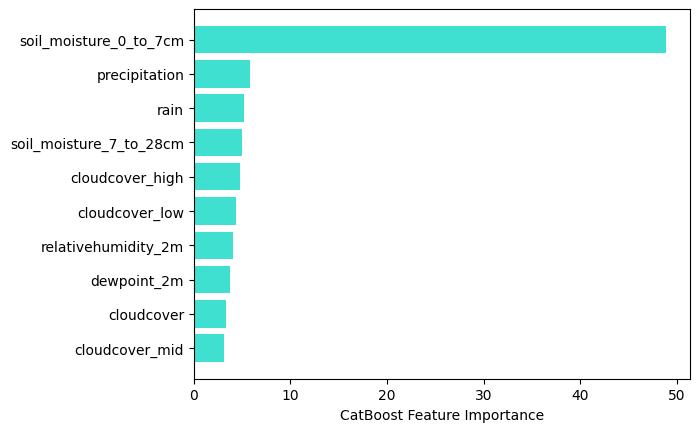

In [ ]:
sorted_feature_importance = model.feature_importances_.argsort()
cols = X.columns[sorted_feature_importance]
temp = model.feature_importances_[sorted_feature_importance]


plt.barh(cols[-10:], 
       temp[-10:], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

#Explainable AI -> Model Function

In [ ]:
! pip install shapely

In [ ]:
! pip install shap

In [ ]:
import shap

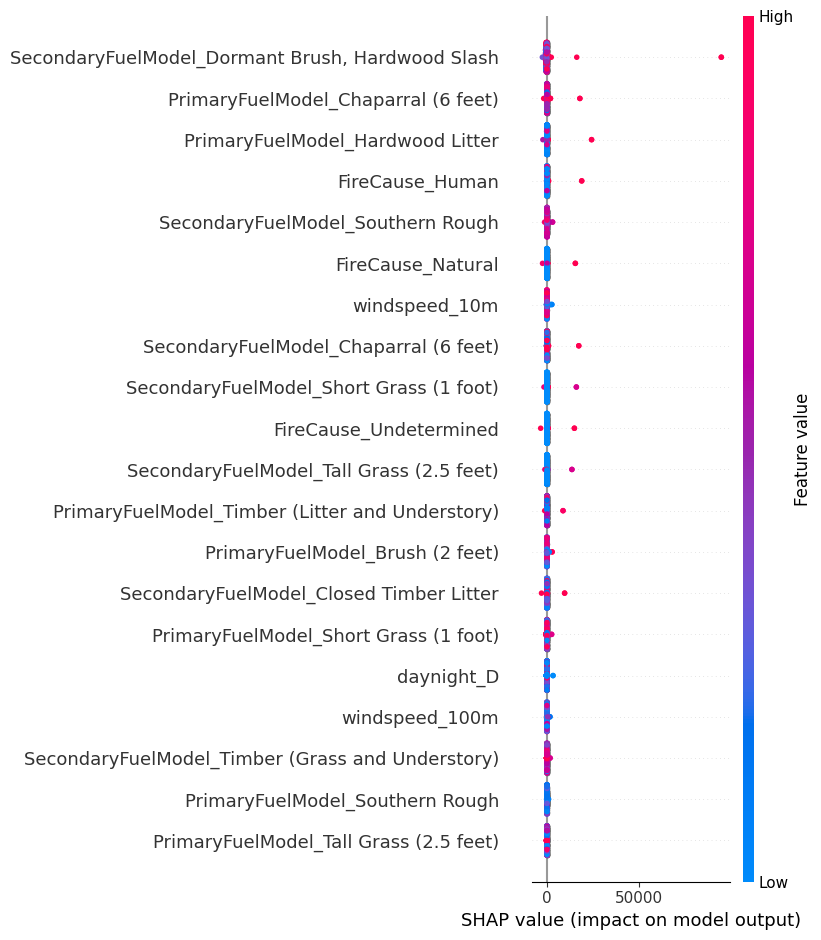

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, feature_names = cols)

# XGBoost (Our Proposed Model for Large Amount of Test Data)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from xgboost.sklearn import XGBRegressor
import time

'''
******XGBoost*******
'''
clf = XGBRegressor(n_estimators=550,
                     max_depth=15,
                     max_leaves=40,
                     eta=0.04,
                     reg_lambda=1,
                     tree_method='hist',
                     eval_metric='rmse',
                     use_label_encoder=True,
                     random_state=1000,
                     n_jobs=-1)

clf.fit(X_train,y_train)

#check the runtime of the model
start = time.time() 
elapsed = time.time() - start
print(f'XGB Training ran in {elapsed:.5f} seconds')
y_pred = clf.predict(X_val)

In [ ]:
mean_squared_error(y_val, y_pred)

In [ ]:
mean_squared_error(y_val, y_pred)**0.5

9.190554155576708